In [1]:
!pip install python_speech_features

In [2]:
import os 
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
import wave

In [3]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(1):
        for y in range(6):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(1):
        for y in range(6):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [5]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(6):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(6):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1



In [0]:
from google.colab import files
uploaded = files.upload()

Saving total00.csv to total00.csv


In [7]:
import io


df = pd.read_csv('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/total00.csv')

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
df.head()

,audiofile,label
0,scream8.wav,scream
1,scream287.wav,scream
2,scream286.wav,scream
3,scream114.wav,scream
4,scream97.wav,scream


In [9]:
df.set_index('audiofile',inplace=True)

In [10]:
df.head()

,label
audiofile,
scream8.wav,scream
scream287.wav,scream
scream286.wav,scream
scream114.wav,scream
scream97.wav,scream


In [0]:
# count=0
# for f in df.index:
#     print(f)
    
#     rate, signal = wavfile.read('wavfiles/'+f)
#     print(rate,signal)
#     count+=1
#     print(f)
# print(count)

In [11]:
for f in df.index:
#     print(f)
    rate, signal = wavfile.read('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/data/'+f)
#     print(signal.shape)
    df.at[f,'length']=signal.shape[0]/rate

/home/bhrigu/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [0]:
df.head()

,label,length
audiofile,,
conv35.wav,Conversations,2.0
conv17.wav,Conversations,2.0
conv10.wav,Conversations,2.0
conv11.wav,Conversations,2.0
conv44.wav,Conversations,2.0


In [12]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

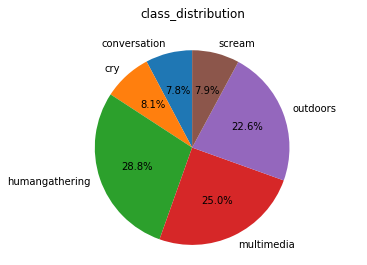

In [13]:
fig, ax= plt.subplots()
ax.set_title('class_distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index, autopct='%1.1f%%',shadow= False, startangle=90)
ax.axis('equal')
plt.show()

In [14]:
df.reset_index(inplace=True)

## Data Cleaning

In [15]:
signals={}
fft={}
filter_banks={}
mfcc_dict= {}

In [16]:
# Calculating fft
def cal_fft(y,rate):
    n=len(y)
    frequency=np.fft.rfftfreq(n,d=1/rate)
    Y=abs(np.fft.rfft(y)/n)
    return (Y,frequency)


In [17]:
#envolope function for removing the dead signals and for rolling window in the signal

def envolope(y,rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    
    for mean in y_mean:
        
        if mean > threshold :
            mask.append(True)
        else:
            mask.append(False)
            
    return mask
    

In [19]:
for c in classes:
    wave_file=df[df.label==c].iloc[0,0]
    signal,rate=librosa.load('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/data/'+wave_file,sr=44100)
#     print(signal,rate)
    mask=envolope(signal,rate,0.0005)
    signal=signal[mask]
    signals[c]=signal
    fft[c]=cal_fft(signal,rate)
    
    bank=logfbank(signal[:rate],rate, nfilt=26, nfft=1103).T
    filter_banks[c]=bank
#     44100/40=1102.5
    mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1103).T
    mfcc_dict[c]=mel
    

# print(fft)
# plot_fft(fft)
# plt.show()

### Plots

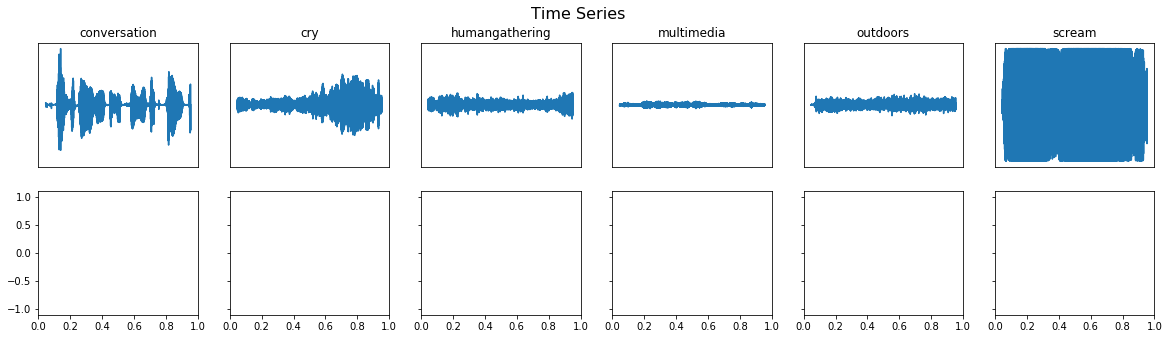

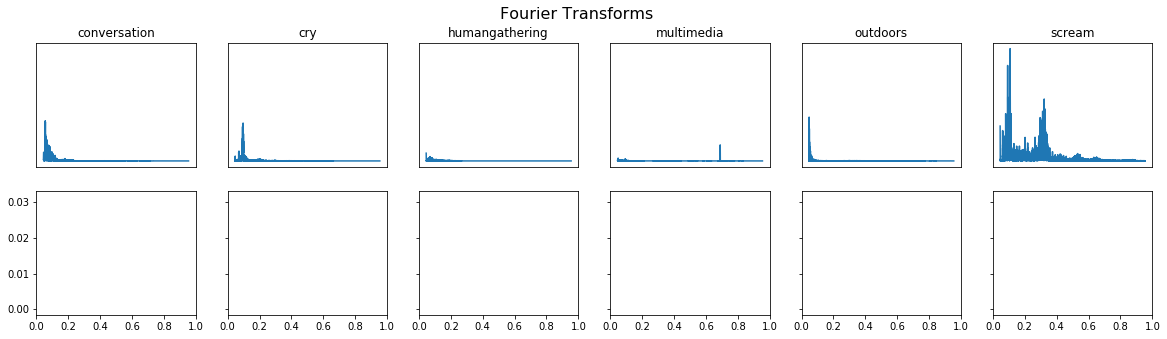

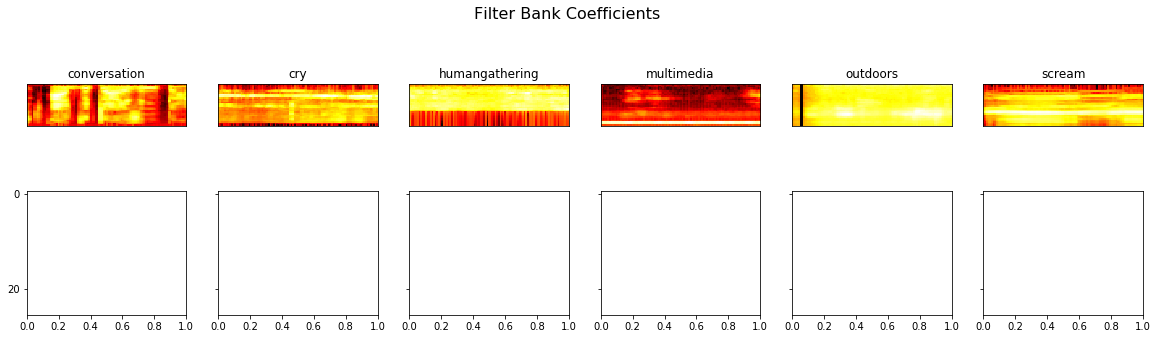

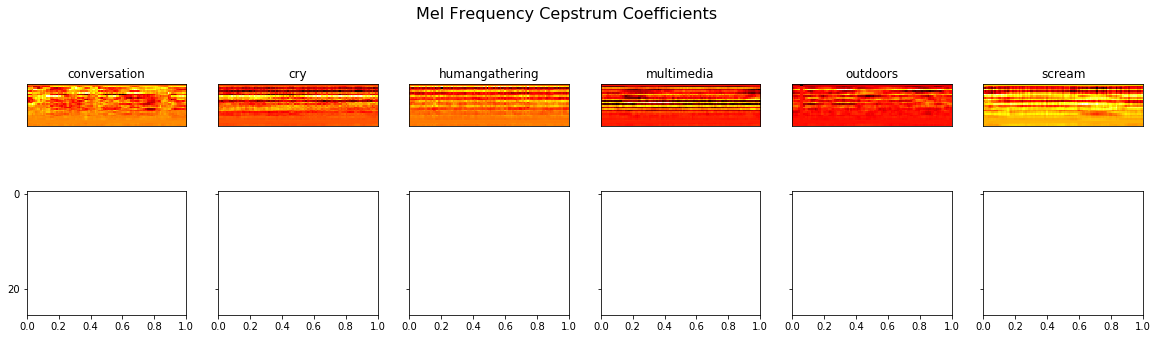

In [20]:
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(filter_banks)
plt.show()

plot_mfccs(mfcc_dict)
plt.show()

In [21]:
if len(os.listdir('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/cleaned_data/'))==0:
    
    for f in tqdm(df.audiofile):
        signal,rate=librosa.load('/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/data/'+f,sr=16000)
        mask=envolope(signal,rate,0.0005)
        wavfile.write(filename='/home/bhrigu/Desktop/celestini_api/Notebooks/pilot_dataset/cleaned_data/'+f,rate=rate,data=signal[mask])
    

100%|██████████| 2319/2319 [21:27<00:00,  3.23it/s]
